<a href="https://colab.research.google.com/github/Hbasgol/qlearningwithfunctionapproximation/blob/master/qlearning_functionapproximation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Python libraries

import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
from gym.wrappers.monitoring import video_recorder
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import numpy as np
import math
from matplotlib import pyplot as plt

In [0]:
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!mkdir videos

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('videos/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    
def make_video(env, trialNo = 0):
  video_render = video_recorder.VideoRecorder(env, './videos/trial.mp4')
  return video_render

mkdir: cannot create directory ‘videos’: File exists


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


• VIDEO: Episode: 0, Score mean for the episode: 54.0 •


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


• VIDEO: Episode: 100, Score mean for the episode: 79.26 •
• VIDEO: Episode: 200, Score mean for the episode: 1500.0 •


◙ Played 200 episodes. Solved after total 157980 trials ◙
Episode 200
current mean: 1500.0
Scores of the agent: [54, 14, 22, 14, 25, 13, 25, 15, 19, 16, 37, 12, 42, 14, 30, 24, 23, 20, 25, 22, 23, 12, 16, 41, 29, 34, 37, 13, 12, 63, 45, 14, 9, 62, 15, 38, 52, 56, 41, 61, 9, 110, 46, 86, 59, 11, 67, 54, 15, 88, 64, 49, 39, 25, 24, 41, 98, 14, 30, 125, 219, 251, 73, 12, 26, 205, 56, 23, 70, 36, 50, 268, 50, 8, 312, 131, 91, 117, 109, 15, 197, 16, 68, 81, 122, 344, 297, 294, 289, 66, 89, 98, 62, 130, 546, 108, 26, 434, 116, 87, 195, 261, 143, 629, 314, 181, 366, 653, 745, 1133, 1411, 496, 426, 1629, 1164, 332, 131, 243, 573, 443, 989, 1390, 2000, 480, 670, 487, 336, 2000, 743, 186, 2000, 133, 2000, 2000, 803, 2000, 552, 2000, 1788, 2000, 2000, 2000, 2000, 2000, 2000, 67, 1086, 258, 2000, 2000, 2000, 832, 466, 2000, 2000, 2000, 2000, 2000, 2000, 1803, 2000, 2000, 2000, 2000, 2000, 2000, 1658, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 20

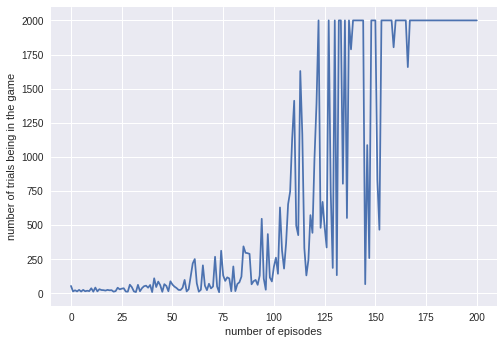

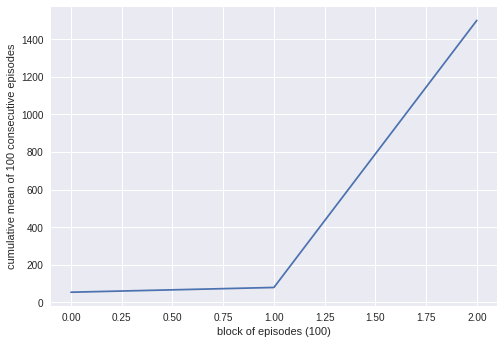

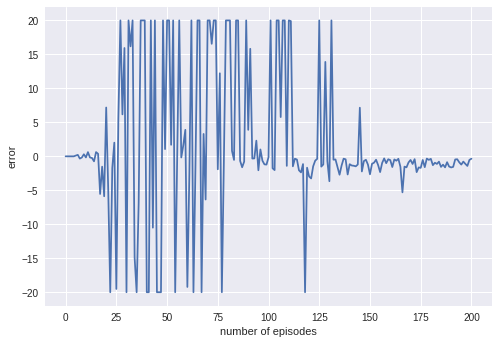

In [0]:
class Agent(): # class defined for the the agent playing the game.
  def __init__(self, Environment, epsilon=0.1, gamma=0.999):
    self.epsilon= epsilon
    self.gamma=gamma
    self.env=Environment.env
    self.scores=[]

  def take_action(self, epsilon, propagations):
    if np.random.random() <= epsilon: #epsilon: greedy search parameter
      return self.env.action_space.sample() #returns a random action
    else:
      return np.argmax(propagations) 
     
  def decayingepsilon(self, t):
    return max(self.epsilon, min(1, 1.0 - math.log10((t + 1) / 25)))
  
class Environment(): # class defined for the environment that is being played on.
  def __init__(self, max_episode_steps):
    self.env = gym.make('CartPole-v0')
    self.max_episode_steps=max_episode_steps
    self.env._max_episode_steps=max_episode_steps # maximum steps for the game

class Rules(): # rules of the game, such as episodes and the winning condition
  def __init__(self, episodes, winning_condition):
    self.episodes=episodes
    self.winning_condition=winning_condition # normally the agent should reach 195 for 100 consecutive trials to win cart-pole
  def terminate_condition(self, observation):
    return -2.4 < observation[0] and observation[0] < 2.4

class NeuralNetwork(): # neural network class for function approximation
  def __init__(self, Environment, learningrate):
    self.env=Environment.env
    self.input = self.env.observation_space.shape[0] + 5
    self.output = 1
    self.W1 = np.zeros((self.input, self.output))
    self.learningrate=learningrate
    self.initialweights=[self.W1]

  def forward_vector(self, observation, job):
    f0_vector = np.append([1], observation)
    f0_vector = np.append(f0_vector, [0, 0, 0, 0])
    
    f1_vector = np.append([1], [0, 0, 0, 0])
    f1_vector = np.append(f1_vector, observation)
    
    if job=="predict":
      return f0_vector, f1_vector
    if job==0:
      return f0_vector
    if job==1:
      return f1_vector
  
  def forward_propagation(self, f_vector):
    return np.dot(self.W1.T, f_vector)
    
  def train(self, Agent, first_state, second_state, action, reward, terminate="not_terminate"):
    fp_vector = self.forward_vector(first_state, action)
    q_value = self.forward_propagation(fp_vector)
    
    f0_vector, f1_vector = self.forward_vector(second_state, job="predict")
    propagations=[self.forward_propagation(f0_vector), self.forward_propagation(f1_vector)]
    q_max = max(propagations)
    
    if terminate=="terminate":
      target=reward
    else:
      target=reward+Agent.gamma*q_max
      
    error=q_value-target
    error=np.clip(error, -20, 20)
    
    self.W1+=self.learningrate*error*fp_vector.reshape((-1, 1))
    self.W1=np.clip(self.W1, -100, 100)
    return error, propagations
    
def Game(Agent, Environment, Rules, Network):
  meanlist= []
  scores=[]
  error=[]
  done=False
  message=True
    
  for i in range(Rules.episodes):
      
    first_state=Environment.env.reset()
    epsilon = Agent.decayingepsilon(i)
    
    video = make_video(Environment.env, i)
    
    f0_vector, f1_vector = Network.forward_vector(first_state, job="predict")
    predicted_q_values=[Network.forward_propagation(f0_vector), Network.forward_propagation(f1_vector)]
    action = Agent.take_action(epsilon, predicted_q_values)
   
    k=0
    done_k=0
    is_first=True
    
    while k <= Environment.max_episode_steps:
      k += 1
      if i%100==0:
        video.capture_frame()
     
      second_state, reward, done, info = Environment.env.step(action)
 
      if done:
        if is_first:
          done_k = k
          is_first=False
      if not Rules.terminate_condition(second_state):
        error_t, action = Network.train(Agent, first_state, second_state, action, reward, terminate="terminate")
        break
      error_t, predicted_q_values = Network.train(Agent, first_state, second_state, action, reward)
      action = Agent.take_action(epsilon, predicted_q_values)
      first_state=second_state
    
    done=False
    
    Agent.scores.append(done_k) # the number of steps that the agent were in the game (done_k)
    scores.append(done_k)
    mean=np.mean(scores) # caution, total trial is fixed to 2000. 
    error.append(error_t)
    
    if i%100==0:    
      print("• VIDEO: Episode: {}, Score mean for the episode: {} •".format(i, mean))
      meanlist.append(mean)
      scores=[]
      video.close()
      Environment.env.close()
      if i%200==0:
        show_video()   
      if mean>=Rules.winning_condition and i!=0:
        print('◙ Played {} episodes. Solved after total {} trials ◙'.format(i, sum(Agent.scores)))
        print("Episode {}".format(i))
        print("current mean:", mean)
        break
  
  return Environment, Agent, meanlist, scores, error

Environment = Environment(2000)
Agent = Agent(Environment)
Network = NeuralNetwork(Environment, 0.00003)
Rules = Rules(600, 195)
Environment, Agent, meanlist, scores, error = Game(Agent, Environment, Rules, Network)

print("Scores of the agent:", Agent.scores)
print("Mean of blocks (100 episodes)", meanlist)

plt.plot(range(0, len(Agent.scores)), Agent.scores)
plt.xlabel("number of episodes")
plt.ylabel("number of trials being in the game") 
plt.show()

plt.plot(range(0, len(meanlist)), meanlist)
plt.xlabel("block of episodes (100)")
plt.ylabel("cumulative mean of 100 consecutive episodes")
plt.show()

plt.plot(range(0, len(error)), error)
plt.xlabel("number of episodes")
plt.ylabel("error")
plt.show()
